In [1]:
# pip install -U albumentations

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
from collections import namedtuple
import numpy as np
import pickle
import os


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


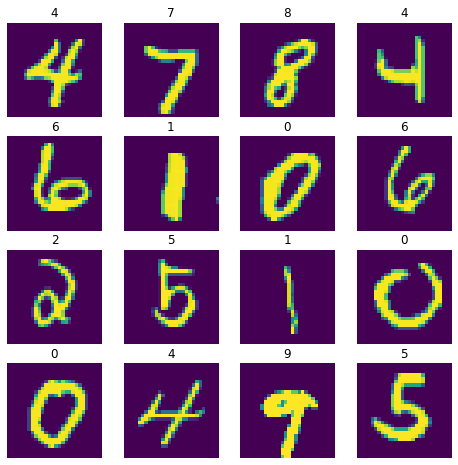

In [4]:
# dataset
dataset_name = 'MNIST'
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
} if dataset_name == 'MNIST' else {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
} 
n_class = 10

class DataModel():
  def __init__(self, transform=None):
    self.transform = tt.Compose([
        tt.ToTensor(),
    ]) if not transform else transform
    self.training_data = self.test_data = None
    self.training_loader = self.training_loader = None
    # self.test_image = self.test_labels = None

  def prepare_data(self):
    self.training_data = datasets.MNIST("data", train=True, download=True, transform=self.transform)
    self.test_data = datasets.MNIST("data", train=False, download=True, transform=self.transform)
    print(self.training_data.data.shape)
    print(self.test_data.data.shape)

  def prepare_loader(self, batch_size=64):
    self.training_loader = DataLoader(self.training_data, batch_size=batch_size, shuffle=True, num_workers=2)
    self.test_loader = DataLoader(self.test_data, batch_size=64, shuffle=True)
    # Plot some data
    fig = plt.figure(figsize=(8, 8))
    for X, y in self.training_loader:
      X = X.squeeze()
      for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.title(labels_map[y[i].item()])
        plt.axis(False)
        plt.imshow(X[i])
      plt.show()
      break
  
  def get_training_loader(self):
    return self.training_loader
  
  def get_test_loader(self):
    return self.test_loader

dm = DataModel()
dm.prepare_data()
dm.prepare_loader()

In [5]:
# Model
class Discriminator(nn.Module):
  def __init__(self, n_class):
    super().__init__()
    self.n_class = n_class
    self.label_embeded = nn.Embedding(n_class, n_class)
    self.features = self.make_feature()
    self.classifier = nn.Sequential(
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
  
  def make_feature(self):
    c_in = 28*28 + self.n_class
    config = [512, 256, 128]
    layers = []
    for i in range(len(config)):
      layers += [nn.Linear(c_in, config[i]), nn.LeakyReLU(negative_slope=0.2), nn.Dropout(p=0.3)]
      c_in = config[i]
    return nn.Sequential(*layers)

  def forward(self, x, labels):
    out = torch.hstack((x.view(x.size(0), -1), self.label_embeded(labels)))
    out = self.features(out)
    out = self.classifier(out)
    return out
  
class Generator(nn.Module):
  def __init__(self, n_class):
    super().__init__()
    self.n_class = n_class
    self.label_embeded = nn.Embedding(n_class, n_class)
    self.features = self.make_feature()
    self.out = nn.Sequential(
        nn.Linear(512, 28*28),
        nn.Tanh(),
    )
  
  def make_feature(self):
    c_in = 100 + self.n_class
    config = [128, 256, 512]
    layers = []
    for i in range(len(config)):
      layers += [nn.Linear(c_in, config[i]), nn.LeakyReLU(negative_slope=0.2), nn.Dropout(p=0.3)]
      c_in = config[i]
    return nn.Sequential(*layers)

  def forward(self, z, labels):
    out = self.features(torch.hstack((z, self.label_embeded(labels))))
    out = self.out(out).view(z.size(0), 28, 28)
    return out
  
discriminator = Discriminator(n_class).to(device)
print('---Discriminator---')
for name, parameter in discriminator.named_parameters():
  print(parameter.device, ' ', name)
generator = Generator(n_class).to(device)
print('---Generator---')
for name, parameter in generator.named_parameters():
  print(parameter.device, ' ', name)


---Discriminator---
cuda:0   label_embeded.weight
cuda:0   features.0.weight
cuda:0   features.0.bias
cuda:0   features.3.weight
cuda:0   features.3.bias
cuda:0   features.6.weight
cuda:0   features.6.bias
cuda:0   classifier.0.weight
cuda:0   classifier.0.bias
---Generator---
cuda:0   label_embeded.weight
cuda:0   features.0.weight
cuda:0   features.0.bias
cuda:0   features.3.weight
cuda:0   features.3.bias
cuda:0   features.6.weight
cuda:0   features.6.bias
cuda:0   out.0.weight
cuda:0   out.0.bias


In [6]:
# Loss
adversarial_loss = nn.BCELoss().to(device)
# Prepare optimizer
d_optim = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optim = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
def view_sample(generator):
  z = torch.from_numpy(np.random.normal(0, 1, size=(16, 100))).float().to(device)
  gen_labels = torch.randint(0, n_class, (16,)).to(device)
  with torch.no_grad():
    generated_img = generator(z, gen_labels)
  plt.figure(figsize=(4, 4))
  for i in range(len(generated_img)):
    img = generated_img[i].reshape(28, 28)
    plt.subplot(4, 4, i+1)
    plt.axis(False)
    plt.imshow(img.to('cpu'))
  plt.show()

Epoch 1/20
Dissciminator loss  0.5436464549560569
Generator loss  2.2947778658572036


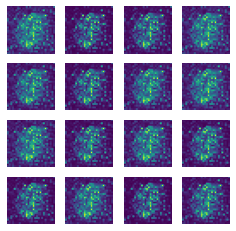

Epoch 2/20
Dissciminator loss  0.30558944889493206
Generator loss  3.4965214215234908


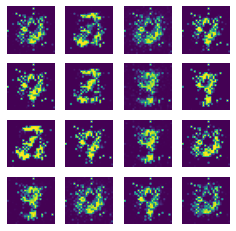

Epoch 3/20
Dissciminator loss  0.30185676465776046
Generator loss  3.6587718376345726


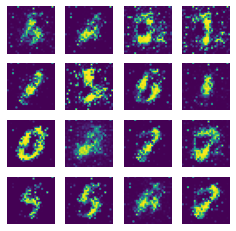

Epoch 4/20
Dissciminator loss  0.3748985300027231
Generator loss  3.138950215855133


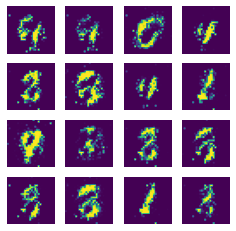

Epoch 5/20
Dissciminator loss  0.45623188399112047
Generator loss  2.7664189820350615


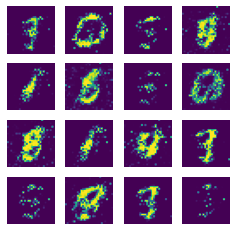

Epoch 6/20
Dissciminator loss  0.546147620547682
Generator loss  2.4300974396500252


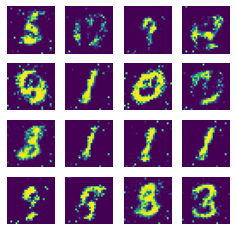

Epoch 7/20
Dissciminator loss  0.642568457005883
Generator loss  2.151228697760019


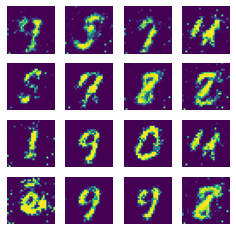

Epoch 8/20
Dissciminator loss  0.7636283812111121
Generator loss  1.7928145654928456


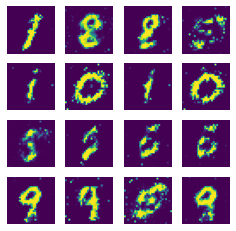

Epoch 9/20
Dissciminator loss  0.8191785372015256
Generator loss  1.6806332632295613


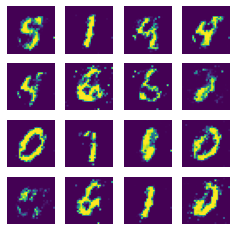

Epoch 10/20
Dissciminator loss  0.8575220315822406
Generator loss  1.59732327627729


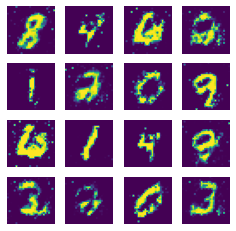

Epoch 11/20
Dissciminator loss  0.8959805361751808
Generator loss  1.513464948960713


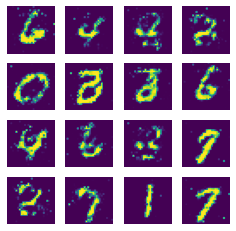

Epoch 12/20
Dissciminator loss  0.9315189309974214
Generator loss  1.4491660487550153


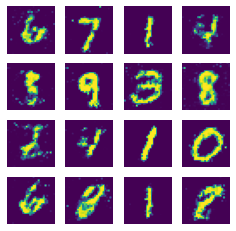

Epoch 13/20
Dissciminator loss  0.9629130609381173
Generator loss  1.3840239316796952


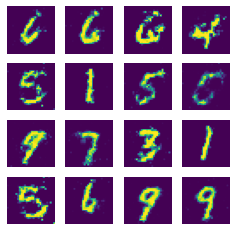

Epoch 14/20
Dissciminator loss  1.0120700257800535
Generator loss  1.3015305793869978


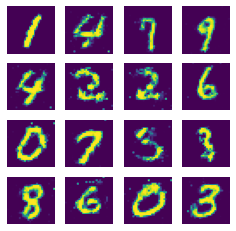

Epoch 15/20
Dissciminator loss  1.029654472430886
Generator loss  1.2608589491864512


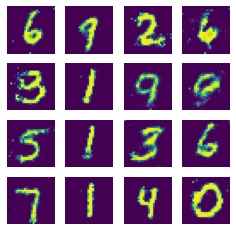

Epoch 16/20
Dissciminator loss  1.0424614180761105
Generator loss  1.2421564780064482


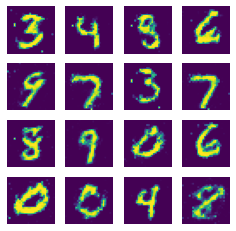

Epoch 17/20
Dissciminator loss  1.0597178159492102
Generator loss  1.2124943611845533


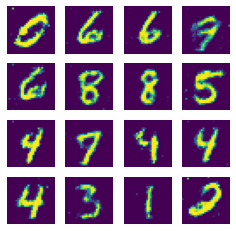

Epoch 18/20
Dissciminator loss  1.0650786074366905
Generator loss  1.1991916227696546


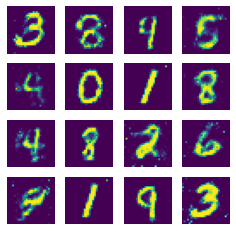

Epoch 19/20
Dissciminator loss  1.0806433575621037
Generator loss  1.175983926825432


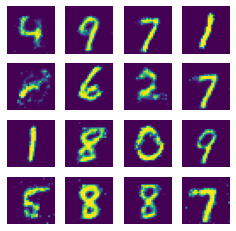

Epoch 20/20
Dissciminator loss  1.0911923848998064
Generator loss  1.1518540510109492


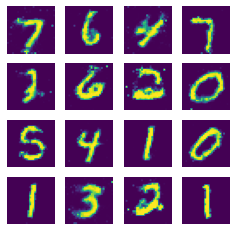

In [8]:
# Train
def train(discriminator, d_optim, generator, g_optim, epochs, device, epoch_d_losses, epoch_g_losses):
  discriminator.train()
  generator.train()
  for epoch in range(epochs):
    d_losses = []
    g_losses = []
    # Train discriminator
    print('Epoch {}/{}'.format(epoch+1, epochs))
    for i, (images, labels) in enumerate(dm.get_training_loader()):
      images = 2*images.to(device) - 1
      labels = labels.to(device)
      # Valid data
      valid_real_data = torch.ones(len(images), requires_grad=False).to(device)
      valid_fake_data = torch.zeros(len(images), requires_grad=False).to(device)
      # latent vector
      z = torch.from_numpy(np.random.normal(0, 1, size=(len(images), 100))).float().to(device)
      gen_labels = torch.randint(0, n_class, (len(images), )).to(device)
      # Train G
      g_optim.zero_grad()
      fake_data = generator(z, gen_labels)
      g_loss = adversarial_loss(discriminator(fake_data, gen_labels).squeeze(), valid_real_data)
      g_loss.backward()
      g_optim.step()
      g_losses.append(g_loss.item())
      # Train D
      d_optim.zero_grad()
      d_loss = adversarial_loss(discriminator(images, labels).squeeze(), valid_real_data) + adversarial_loss(discriminator(fake_data.detach(), gen_labels.detach()).squeeze(), valid_fake_data)
      d_loss.backward()
      d_optim.step()
      d_losses.append(d_loss.item())
    
    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))
    print('Dissciminator loss ', epoch_d_losses[-1])
    print('Generator loss ', epoch_g_losses[-1])
    generator.eval()
    view_sample(generator)
    generator.train()

epochs = 20
epoch_d_losses = []
epoch_g_losses = []
train(discriminator, d_optim, generator, g_optim, epochs, device, epoch_d_losses, epoch_g_losses)

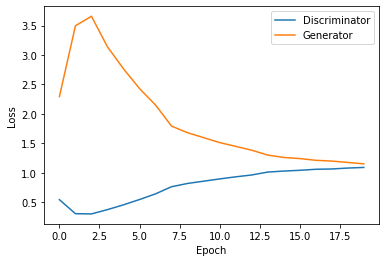

In [9]:
# Discrimination loss during training
plt.figure()
plt.plot(epoch_d_losses)
plt.plot(epoch_g_losses)
plt.legend(['Discriminator', 'Generator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [10]:
# Save model
base_name = './model/cgan'
if not os.path.isdir(base_name):
    os.mkdir(base_name)
discriminator_file_path = os.path.join(base_name, 'discriminator.sav')
generator_file_path = os.path.join(base_name, 'generator.sav')

with open (discriminator_file_path, 'wb') as d_file:
    pickle.dump(discriminator, d_file)
with open (generator_file_path, 'wb') as g_file:
    pickle.dump(generator, g_file)

In [11]:
# Load adversarial model
with open(discriminator_file_path, 'rb') as d_file:
    discriminator = pickle.load(d_file)
with open(generator_file_path, 'rb') as g_file:
    generator = pickle.load(g_file)

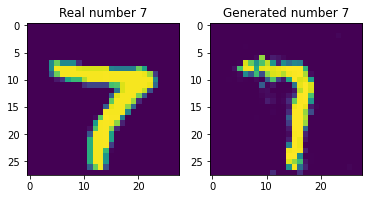

Probability real image:  0.6216683983802795


In [14]:
discriminator.to('cpu')
discriminator.eval()
generator.to('cpu')
generator.eval()

plt.figure()
# Show real image
real_img, label = next(iter(dm.get_test_loader()))
real_img = real_img[0]
label = torch.from_numpy(np.array([label[0]]))
plt.subplot(1, 2, 1)
plt.title('Real number %d' % label.item())
plt.imshow(real_img.squeeze())
# Show generated image
z = torch.from_numpy(np.random.normal(0, 1, size=(1,100))).float()
fake_img = generator(z, label)
max_prob = 0
realest_img = fake_img
plt.subplot(1, 2, 2)
plt.title('Generated number %d' % label.item())
for i in range(200):
  prob = discriminator(fake_img, label).item()
  if prob > max_prob:
    max_prob = prob
    realest_img = fake_img
  z = torch.from_numpy(np.random.normal(0, 1, size=(1,100))).float()
  fake_img = generator(z, label)

plt.imshow(realest_img.detach().squeeze())
plt.show()
# discriminator
print('Probability real image: ', max_prob)

    
